In [1]:
import sys
import os
import getpass

# Path to where your CaloQVAE dir is
# upper_dir = 'WLVAE'
# # Path to where your CaloQVAE dir is
# os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
# sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
# sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())

In [2]:
import h5py
import numpy as np

In [3]:
xtarget_samples = h5py.File('/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5', 'r')
# gen_data = h5py.File("/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_denim-smoke-166en130.hdf5", 'r')
gen_data = h5py.File("/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_morning-bush-469.hdf5", 'r')
# gen_data = h5py.File("/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_robust-serenity-216en150.hdf5", 'r')
# gen_data = h5py.File("/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_royal-thunder-232en100.hdf5", 'r')
xtarget_samples = torch.tensor(np.array(xtarget_samples['showers']))
xgen_samples = torch.tensor(np.array(gen_data['showers']))

In [4]:
# xgen_samples = torch.load('/home/' + getpass.getuser() +'/samples/xgen_samples.pt')
# xrecon_samples = torch.load('/home/' + getpass.getuser() + '/samples/xrecon_samples.pt')
# xtarget_samples = torch.load('/home/' + getpass.getuser() + '/samples/xtarget_samples.pt')
# entarget_samples = torch.load('/home/' + getpass.getuser() + '/samples/entarget_samples.pt')

In [5]:
def measure_single_granularity(data_tensor_1, index):
    """
    Measure the granularity of a calorimeter image given as a 1D array using PyTorch.
    
    Parameters:
    data (array-like): 1D array representing the calorimeter image.
    
    Returns:
    float: A measure of the granularity.
    """
    # Calculate the differences between consecutive elements
#     diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])/torch.mean(data_tensor_1[:,:-index], dim = 1, keepdim=True)
    diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])
#     std_g = torch.std(diffs_1, dim = 1)
    return diffs_1


def measure_stochastic_granularity(data_tensor):
    segment_length = 144  # Length of each segment
    num_segments = 45     # Number of segments per sample
    num_samples = data_tensor.size(0)  # Number of samples in the data tensor

    # Use PyTorch to generate a random integer array of shape (num_samples,) with values between 0 and 15
    random_array = torch.randint(0, 16, (num_samples,), dtype=torch.int64, device=data_tensor.device)

    # Multiply random_array by 9 and expand it to shape (num_samples, num_segments)
    shifts = (random_array * 9).unsqueeze(-1).expand(-1, num_segments)

    # Unfold the data tensor to create segments of length 144
    # The result is a tensor of shape (num_samples, num_segments, segment_length)
    segments = data_tensor.unfold(1, segment_length, segment_length)

    # Create an indices tensor of shape (num_samples, num_segments, segment_length)
    indices = torch.arange(segment_length, device=data_tensor.device).repeat(num_samples, num_segments, 1)
    # Adjust the indices by adding the shifts and applying modulo operation to wrap around
    indices = (indices + shifts.unsqueeze(-1)) % segment_length  # Ensure correct broadcasting

    # Gather elements from the segments tensor using the adjusted indices
    rotated_segments = torch.gather(segments, 2, indices)

    # Reshape the rotated_segments tensor back to the original shape of data_tensor
    result_tensor = rotated_segments.view(num_samples, -1)

    # Compute the difference between the original data tensor and the result tensor
    diffs = data_tensor - result_tensor
    
    return diffs                   

def measure_zaxis_granularity(data, start_layer_1, start_layer_2, layer_size):
    s1 = start_layer_1 * 144
    s2 = start_layer_2 * 144
    s1_end = s1 + 144 * layer_size
    s2_end = s2 + 144 * layer_size
    return data[:, s1:s1_end] - data[:, s2:s2_end]

In [6]:
# granularity_target = measure_single_granularity(xtarget_samples,9)
# # granularity_sample = measure_single_granularity(xgen_samples,9)
# granularity_recon = measure_single_granularity(xrecon_samples,9)

granularity_target = measure_stochastic_granularity(xtarget_samples)
granularity_sample = measure_stochastic_granularity(xgen_samples)
std_target = torch.std(granularity_target, dim =1)
std_sample = torch.std(granularity_sample, dim =1)

In [7]:
# xrecon_samples_alt = Final_Dropout(p=0.5, coe = 0.149)(xrecon_samples)
# granularity_recon_alt = measure_stochastic_granularity(xrecon_samples_alt)

In [8]:
granularity_target.shape

torch.Size([100000, 6480])

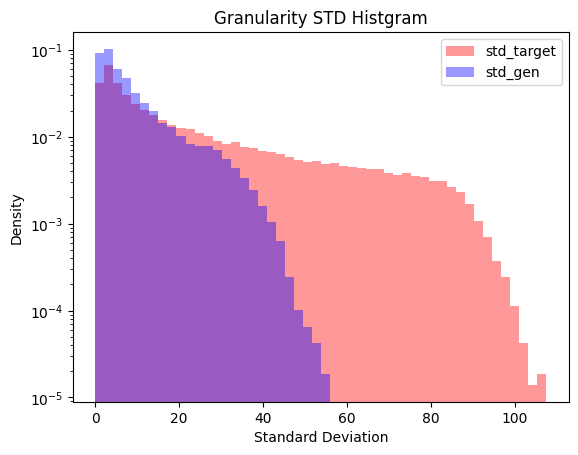

In [9]:
combined_data = np.concatenate((std_target, std_sample))
bins = np.histogram_bin_edges(combined_data, bins=50)
plt.hist(std_target, log=True, color = 'red', bins=bins,alpha = 0.4, label = "std_target", density = True)
plt.hist(std_sample, log=True, color = 'blue', alpha = 0.4, bins=bins, label = "std_gen", density = True)
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()
plt.title("Granularity STD Histgram")
plt.show()

In [10]:
# index = []
# error_target_list = []
# error_recon_list = []
# error_alt_list = []
# ratio_list = []
# ratio_list_alt = []
# for i in range(1, 30):
#     error_recon = torch.mean(torch.std(measure_single_granularity(xrecon_samples, i),dim=0))
#     error_target = torch.mean(torch.std(measure_single_granularity(xtarget_samples, i),dim=0))
#     error_alt = torch.mean(torch.std(measure_single_granularity(xrecon_samples_alt, i),dim=0))
#     ratio = error_target/error_recon
#     ratio_alt = error_target/error_alt
#     error_recon_list.append(error_recon)
#     error_target_list.append(error_target)
#     error_alt_list.append(error_alt)
#     ratio_list.append(ratio)
#     ratio_list_alt.append(ratio_alt)
#     index.append(i)

In [11]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# # 在第一个子图中绘制 error_gen_list 和 error_target_list
# ax1.plot(index, error_target_list, label='Target', color='black')
# ax1.plot(index, error_recon_list, label='Recon', color='red')
# ax1.plot(index, error_alt_list, label='Alt_Recon', color='green')
# ax1.legend()
# ax1.set_ylabel('Mean STD')

# # 在第二个子图中绘制 ratio_list
# ax2.plot(index, ratio_list, label='Ratio T/G', color='red')
# ax2.plot(index, ratio_list_alt, label='Ratio T/A', color='green')
# ax2.legend()
# ax2.set_xlabel('Shifting Index')
# ax2.set_ylabel('Ratio')

# plt.show()

In [12]:
granz_target = measure_zaxis_granularity(xtarget_samples, 0, 1, 44)
granz_sample = measure_zaxis_granularity(xgen_samples, 0, 1, 44)
std_target = torch.std(granz_target, dim =1)
std_sample = torch.std(granz_sample, dim =1)

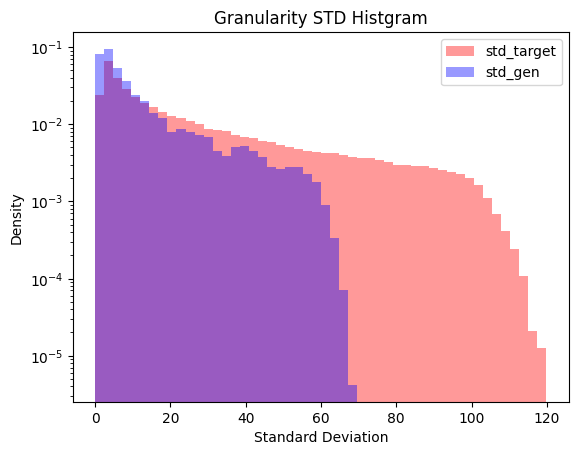

In [13]:
combined_data = np.concatenate((std_target, std_sample))
bins = np.histogram_bin_edges(combined_data, bins=50)
plt.hist(std_target, log=True, color = 'red', bins=bins,alpha = 0.4, label = "std_target", density = True)
plt.hist(std_sample, log=True, color = 'blue', alpha = 0.4, bins=bins, label = "std_gen", density = True)
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()
plt.title("Granularity STD Histgram")
plt.show()

IndexError: list index out of range

<Figure size 800x600 with 0 Axes>

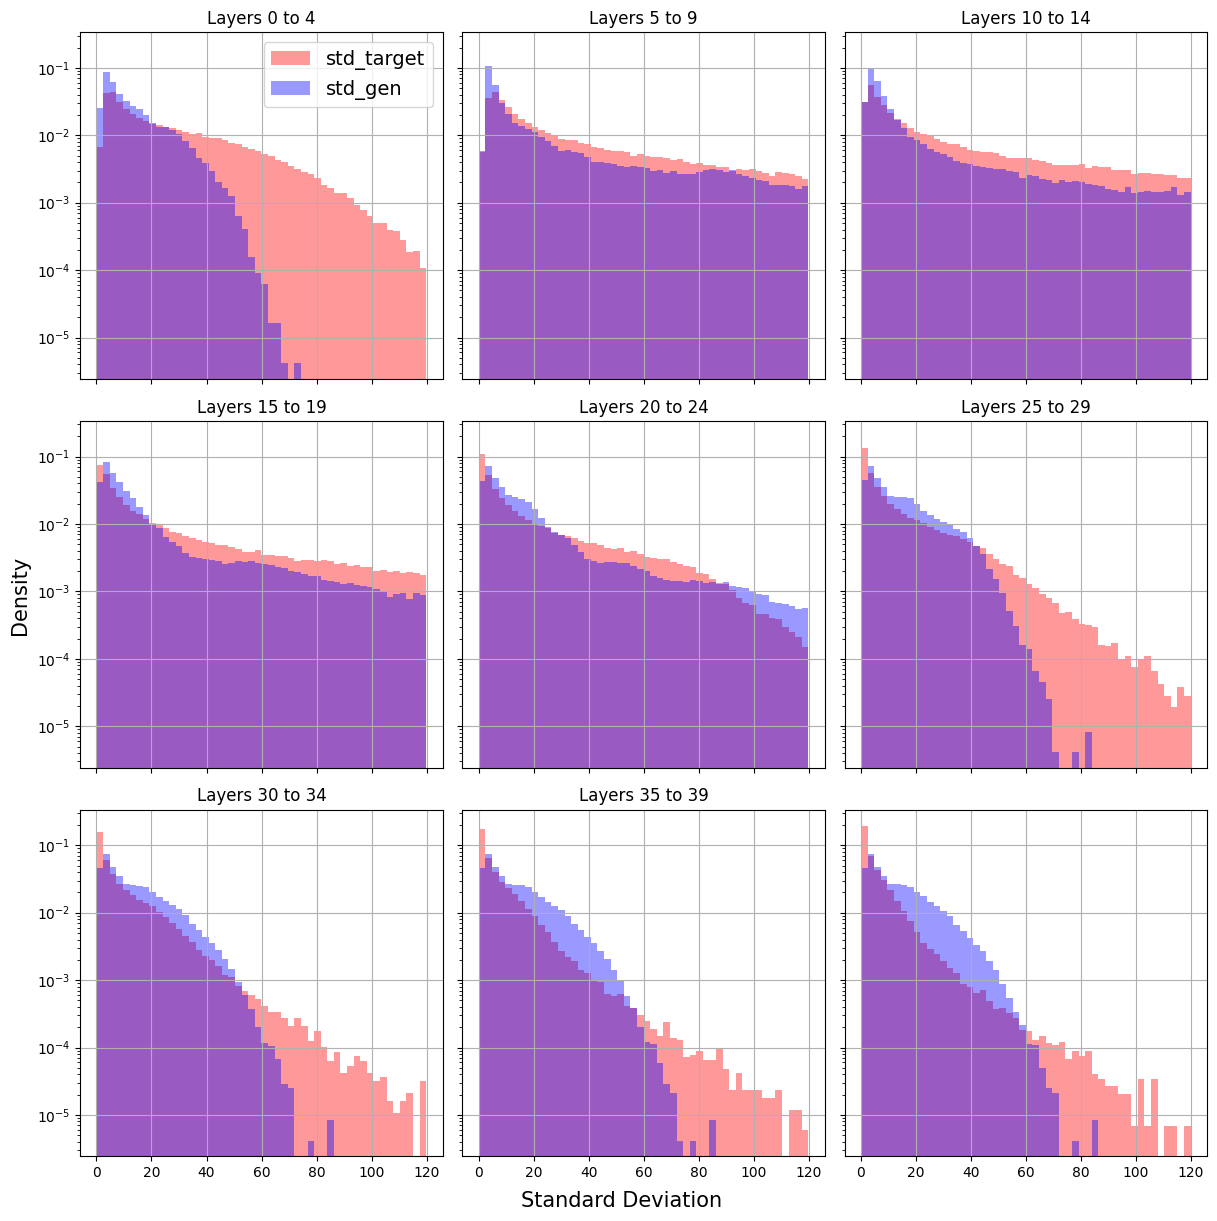

In [14]:
layers = [0,5,10,15,20,25,30,35,40]
ind = 0
layer_size = 4

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Standard Deviation', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i in layers:
    granz_target = measure_zaxis_granularity(xtarget_samples, i, i+1, 4)
    granz_sample = measure_zaxis_granularity(xgen_samples, 0, i+1, 4)
    std_target = torch.std(granz_target, dim =1)
    std_sample = torch.std(granz_sample, dim =1)

    row_index = ind // 3  # Determine the row index
    col_index = ind % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot

    ax.hist(std_target, log=True, color = 'red', bins=bins,alpha = 0.4, label = "std_target", density = True)
    ax.hist(std_sample, log=True, color = 'blue', alpha = 0.4, bins=bins, label = "std_gen", density = True)
    if i == 0:
        ax.legend(["std_target", "std_gen"], fontsize=14, loc = 'upper right')
    ax.grid("True")

    ax.set_title(f'Layers {layers[ind]} to {layers[ind+1]-1}', fontsize=12)
    ind += 1

plt.show()

In [ ]:
# import time
# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=num_segments)
#     result_tensor = torch.empty_like(data_tensor)
#     for row_idx in range(data_tensor.size(0)):  # 遍历每一行
#         row = data_tensor[row_idx]
#         segments = []
#         for i in range(num_segments):
#             segment = row[i*segment_length:(i+1)*segment_length]
#             rotated_segment = torch.roll(segment, shifts=random_array[i]*9)
#             segments.append(rotated_segment)

#         result_tensor[row_idx] = torch.cat(segments)

#     diffs = data_tensor - result_tensor
#     return diffs


# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=num_segments)
#     print(random_array)
    
#     # 创建一个与data_tensor相同形状的tensor
#     result_tensor = torch.empty_like(data_tensor)
    
#     # 预先计算好所有需要的roll shifts
#     shifts = torch.tensor(random_array * 9)

#     # 将data_tensor按照segment_length进行分割
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     # 创建一个空的tensor来存储所有旋转后的segments
#     rotated_segments = torch.empty_like(segments)
    
#     # 使用广播机制计算所有旋转后的segments
#     for i in range(num_segments):
#         rotated_segments[:, i, :] = torch.roll(segments[:, i, :], shifts=shifts[i].item(), dims=1)
    
#     # 将旋转后的segments重新拼接成完整的tensor
#     result_tensor = rotated_segments.reshape(data_tensor.size(0), -1)
    
#     # 计算差异
#     diffs = data_tensor - result_tensor
#     return diffs

# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     num_samples = data_tensor.size(0)
    
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=(num_samples, num_segments))
#     print(random_array)
    
#     shifts = torch.tensor(random_array * 9, dtype=torch.int64)
    
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     indices = torch.arange(segment_length).repeat(num_samples, num_segments, 1)
#     indices = (indices + shifts.unsqueeze(-1)) % segment_length
    
#     rotated_segments = torch.gather(segments, 2, indices)

#     result_tensor = rotated_segments.view(num_samples, -1)
    
#     diffs = data_tensor - result_tensor
#     return diffs

# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144  # Length of each segment
#     num_segments = 45     # Number of segments per sample
#     num_samples = data_tensor.size(0)  # Number of samples in the data tensor
    
#     # Create a random number generator
#     rng = np.random.default_rng()
#     # Generate a random integer array of shape (num_samples, num_segments) with values between 0 and 15
#     random_array = rng.integers(0, 16, size=(num_samples, num_segments))
#     print(random_array)
    
#     # Multiply random_array by 9 and convert to a PyTorch tensor of type int64
#     shifts = torch.tensor(random_array * 9, dtype=torch.int64)
    
#     # Unfold the data tensor to create segments of length 144
#     # The result is a tensor of shape (num_samples, num_segments, segment_length)
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     # Create an indices tensor of shape (num_samples, num_segments, segment_length)
#     # This tensor contains values from 0 to segment_length-1 repeated for each sample and segment
#     indices = torch.arange(segment_length).repeat(num_samples, num_segments, 1)
#     # Adjust the indices by adding the shifts and applying modulo operation to wrap around
#     indices = (indices + shifts.unsqueeze(-1)) % segment_length
    
#     # Gather elements from the segments tensor using the adjusted indices
#     # This effectively rotates each segment by the specified shift amounts
#     rotated_segments = torch.gather(segments, 2, indices)

#     # Reshape the rotated_segments tensor back to the original shape of data_tensor
#     result_tensor = rotated_segments.view(num_samples, -1)
    
#     # Compute the difference between the original data tensor and the result tensor
#     diffs = data_tensor - result_tensor
    
#     return diffs

In [ ]:
st_granularity_target = measure_stochastic_granularity(xtarget_samples)
st_granularity_sample = measure_stochastic_granularity(xgen_samples)
st_granularity_recon = measure_stochastic_granularity(xrecon_samples)

In [ ]:
from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]

In [ ]:
idx= 7000
HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(xrecon_samples_alt[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow') 

In [ ]:
xrecon_samples_alt[7000,:]

In [ ]:
minVal, maxVal = min(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy()), max(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
plt.hist(((xrecon_samples_alt == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
plt.xlabel("Sparsity Index", fontsize=15)
plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Alt_Recon", "Sample /w QPU"], fontsize=17)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(((xrecon_samples_alt[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=14)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
minVal, maxVal = min(xtarget_samples.sum(dim=1).numpy()/1000), max(xtarget_samples.sum(dim=1).numpy()/1000)
binwidth = (maxVal-minVal)/50
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c")
plt.hist(xrecon_samples_alt.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot")

plt.xlabel("Energy per event (GeV)", fontsize=15)

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/30
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xrecon_samples_alt[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]
xtarget_mean = xtarget_samples.mean(dim=0)
xrecon_mean_alt = xrecon_samples_alt.mean(dim=0)
HLF_1_electron.DrawSingleShower(xtarget_mean.detach().cpu().numpy(), vmax=1e+3, vmin=1e+0)
HLF_1_electron.DrawSingleShower(xrecon_mean_alt.detach().cpu().numpy(), vmax=1e+3, vmin=1e+0)